# **Module 1: Introduction to Spatial Data Analysis in Python**
## **Prerequisites**

### Data
In this example, we will use 3 datasets from the Minnesota Geospatial Commons, which have been downloaded, cleaned, transformed and saved to the directory `./data-module-1/` for this workshop.
- `soil_samp_2021-10-05.csv` - Minnesota Six-Inch Soil Temperature: https://gisdata.mn.gov/dataset/geos-soil-temp-network
- `gw_provinces_extra.shp` - Groundwater Provinces of Minnesota 2021: https://gisdata.mn.gov/dataset/geos-groundwater-provinces-mn
- `cdl3_3km.tif` - Cropland Data Layer 2020, Minnesota: https://gisdata.mn.gov/dataset/agri-cropland-data-layer-2020      

### Software
To execute the code you will need a Python environment with the packages imported below.

In [3]:
# general use packages
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from matplotlib.colors import from_levels_and_colors

# geospatial packages
import geopandas as gpd
import rasterio
from rasterio.plot import plotting_extent

Mount your drive, stash any changes and pull the latest version of the repo

In [6]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/git_projects/AE_772_892

!git stash
!git pull

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/git_projects/AE_772_892
Saved working directory and index state WIP on main: 9f49c92 Lecture 4 complete
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 62 (delta 14), reused 62 (delta 14), pack-reused 0
Unpacking objects: 100% (62/62), 11.48 MiB | 4.59 MiB/s, done.
From https://github.com/jancgreyling/AE_772_892
   9f49c92..eb6a7ca  main       -> origin/main
Updating 9f49c92..eb6a7ca
Fast-forward
 .DS_Store                                        |  Bin 6148 -> 6148 bytes
 data/.DS_Store                                   |  Bin 0 -> 6148 bytes
 data/raw/2023_Abstract.xlsx                      |  Bin 0 -> 585415 bytes
 data/raw/data-lecture-6/MN_final_map.jpg         |  Bin 0 -> 153560 bytes
 data/raw/data-lecture-6/MWI_msk_alt.grd         

## **Working with Spatial Points Data in Python**
### Importing XY data

Our first step is to read in the `.csv` file that contains our attribute data with geographic coordinates. For this example, we will be using the *Minnesota Six-Inch Soil Temperature* data.

> The Minnesota Department of Agriculture (MDA) Six-Inch Soil Temperature Network provides real time soil temperatures at locations across Minnesota. The network was established to assist in following best management practices for fall nitrogen fertilizer application, which refer to a soil temperature at a six-inch depth.

For today's workshop, a random October 5, 2021 temperature has been added for illustrative purposes. We read in `.csv` data using the Python `pandas` package, which enables operations on tabular data (data frames).

Read the data

In [7]:
filepath = os.path.join("data","raw","data-lecture-6","soil_samp_2021-10-05.csv")
soil_samp_df = pd.read_csv(filepath)
soil_samp_df

,source,x,y,name,temp_20211005
0,MDA,-94.194226,44.200166,Judson,41.792586
1,MDA,-95.428875,44.762221,Granite Falls,49.429966
2,MDA,-93.268405,43.513998,Gordonsville,37.783807
3,MDA,-94.358969,44.877802,Hutchinson,60.243006
4,MDA,-96.306798,44.003185,Pipestone,58.489282
...,...,...,...,...,...
60,NDAWN,-95.601876,46.610477,Perham,37.697912
61,NDAWN,-94.995800,46.820590,Hubbard,48.817212
62,NDAWN,-95.371700,47.012860,Pine Point,37.371797
63,UMN,-93.180000,44.990000,St. Paul Campus,53.012919


### Convert `DataFrame` to `GeoDataFrame`
In this step we use the spatial information from `x` and `y` columns to convert the initial table `DataFrame` into a `GeoDataFrame` to enable operations for spatial analysis of the features. Because coordinates are supplied in degrees of latitude and longitude, we need to set World Geodetic System 1984 (`epsg:4326`) as a coordinate system.

In [10]:
soil_samp_gdf = gpd.GeoDataFrame(soil_samp_df,
                                 geometry=gpd.points_from_xy(soil_samp_df.x, soil_samp_df.y),
                                 crs="epsg:4326")
soil_samp_gdf

,source,x,y,name,temp_20211005,geometry
0,MDA,-94.194226,44.200166,Judson,41.792586,POINT (-94.19423 44.20017)
1,MDA,-95.428875,44.762221,Granite Falls,49.429966,POINT (-95.42888 44.76222)
2,MDA,-93.268405,43.513998,Gordonsville,37.783807,POINT (-93.26841 43.51400)
3,MDA,-94.358969,44.877802,Hutchinson,60.243006,POINT (-94.35897 44.87780)
4,MDA,-96.306798,44.003185,Pipestone,58.489282,POINT (-96.30680 44.00319)
...,...,...,...,...,...,...
60,NDAWN,-95.601876,46.610477,Perham,37.697912,POINT (-95.60188 46.61048)
61,NDAWN,-94.995800,46.820590,Hubbard,48.817212,POINT (-94.99580 46.82059)
62,NDAWN,-95.371700,47.012860,Pine Point,37.371797,POINT (-95.37170 47.01286)
63,UMN,-93.180000,44.990000,St. Paul Campus,53.012919,POINT (-93.18000 44.99000)


More on projections:

1. Definition: Geographic projection systems are methods used to represent the curved surface of the Earth on a flat map or display.

2. Purpose: Because the Earth is a three-dimensional object and maps are typically two-dimensional, some form of transformation is necessary to depict the Earth's surface in a way that's useful for various applications.

3. Distortions: All map projections introduce some degree of distortion. This can affect areas, angles, distances, and/or directions. No single projection is perfect for all purposes.

4. Types of Projections:

 - Cylindrical Projections: Imagine wrapping a cylinder around the Earth and projecting the Earth's surface onto it. E.g., Mercator projection.
  - Conic Projections: These involve projecting the Earth's surface onto a cone. E.g., Albers Equal Area Conic.
  - Azimuthal Projections: Projecting the Earth's surface onto a plane, typically from a single point of perspective. E.g., Stereographic projection.

5. Choosing a Projection: The choice of projection depends on the purpose of the map. For example, navigational maps might use the Mercator projection because it preserves angles, while maps meant to compare land areas might use an equal-area projection.

6. Datum: A datum defines the position of the spheroid relative to the center of the Earth. It is an essential reference for map projections. The WGS84 datum, used by the GPS system, is among the most common.

https://www.youtube.com/watch?v=vVX-PrBRtTY

### Summarize Point Data

In [11]:
print ("First 5 rows of the GeoDataFrame: ")
soil_samp_gdf.head()

First 5 rows of the GeoDataFrame: 


,source,x,y,name,temp_20211005,geometry
0,MDA,-94.194226,44.200166,Judson,41.792586,POINT (-94.19423 44.20017)
1,MDA,-95.428875,44.762221,Granite Falls,49.429966,POINT (-95.42888 44.76222)
2,MDA,-93.268405,43.513998,Gordonsville,37.783807,POINT (-93.26841 43.51400)
3,MDA,-94.358969,44.877802,Hutchinson,60.243006,POINT (-94.35897 44.87780)
4,MDA,-96.306798,44.003185,Pipestone,58.489282,POINT (-96.30680 44.00319)


In [12]:
print ("Extent of the data is defined by the following bounding box: ")
soil_samp_gdf.total_bounds

Extent of the data is defined by the following bounding box: 


array([-97.150283 ,  43.513998 , -91.8002195,  48.883533 ])

In [13]:
print ("The following contains the information on the Coordinate Reference System: ")
soil_samp_gdf.crs

The following contains the information on the Coordinate Reference System: 


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
print ("Summarize numerical fields")
soil_samp_gdf.describe()

Summarize numerical fields


,x,y,temp_20211005
count,65.000000,65.000000,65.000000
mean,-95.116678,45.713764,49.090586
std,1.303074,1.633838,7.735855
min,-97.150283,43.513998,35.182697
25%,-96.132504,44.238686,42.902563
50%,-95.318131,45.594495,49.429966
75%,-94.251400,46.820590,54.892523
max,-91.800219,48.883533,62.641173


In [15]:
print ("Describe string columns")
soil_samp_gdf.describe(include=[object])

Describe string columns


,source,name
count,65,65
unique,3,64
top,MDA,Campbell
freq,31,2


### Vizualize Point Data

Simple point map


<Axes: >

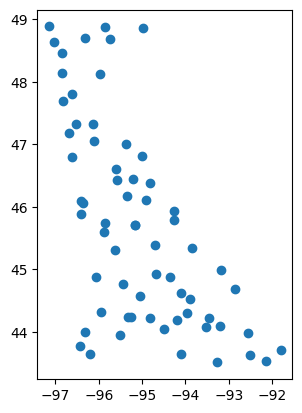

In [16]:
print ("Simple point map")
soil_samp_gdf.plot()

In [18]:
!pip install mapclassify

print ("Interactive map")
soil_samp_gdf.explore()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 969.8 kB/s eta 0:00:00
Interactive map


**Although a simple plot can be easily produced with Python, it is rarely the final product that allows you to explore and share insights about the data. The examples below provide options to create a interactive map and on how you can better control figure aesthetics and add important functional components, such as legend.**

Display categorical values on the plot


<Axes: >

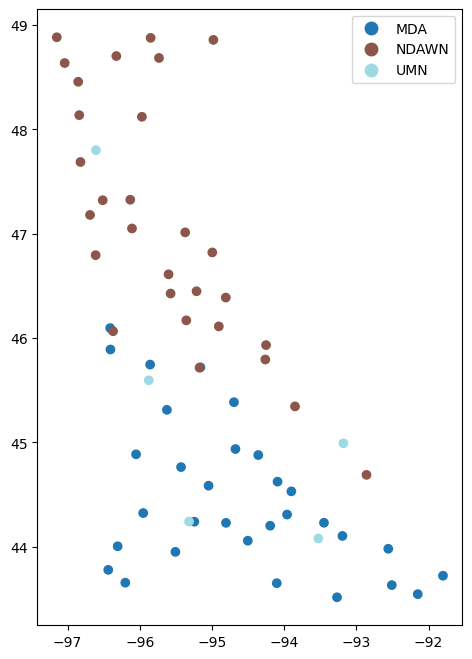

In [ ]:
print ("Display categorical values on the plot")
soil_samp_gdf.plot(column="source", legend=True, cmap="tab20",  categorical=True, figsize=(6,8))

**You can find more information on suported colors and colormaps in `matplotlib` by going to the following links:**
- https://matplotlib.org/stable/tutorials/colors/colormaps.html
- https://matplotlib.org/stable/gallery/color/named_colors.html

Display continuous values on the plot


Text(0.5, 1.0, 'Minnesota Six-Inch Soil Temperature, degrees F')

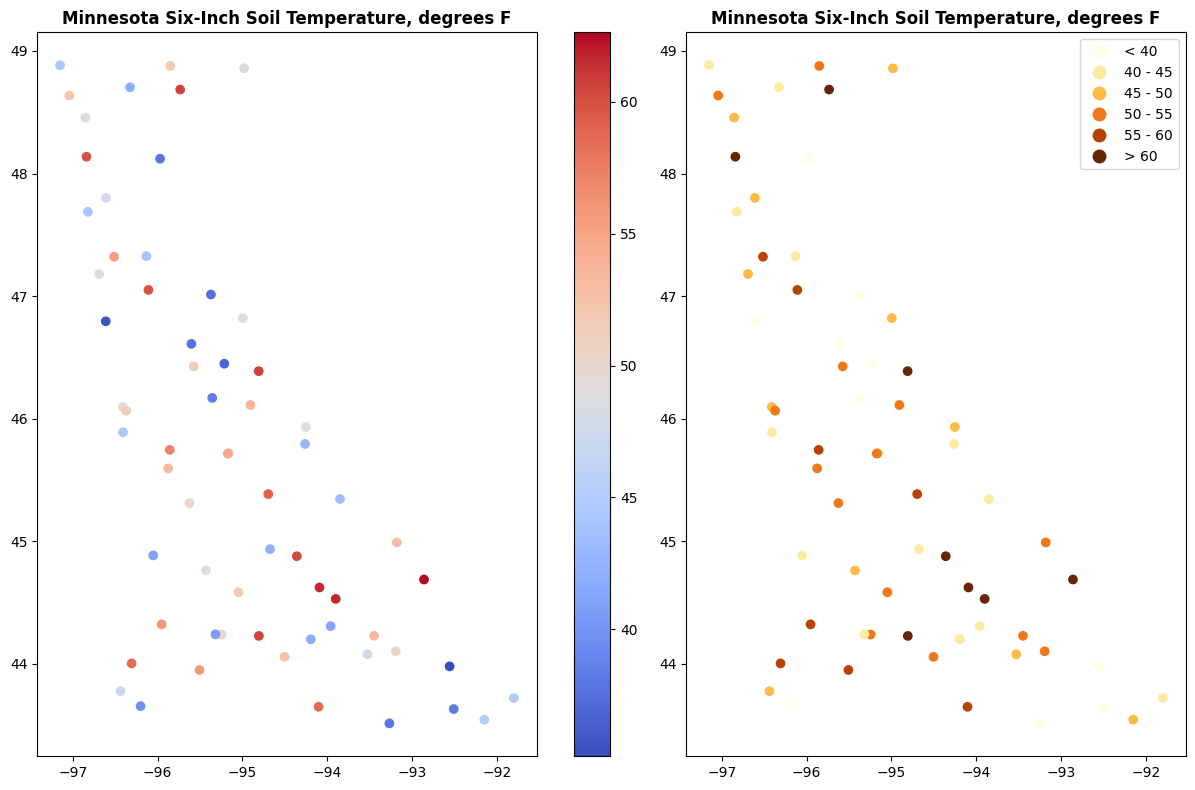

In [19]:
print ("Display continuous values on the plot")
fig, axs = plt.subplots(1,2, figsize=(14,8), tight_layout=True)
soil_samp_gdf.plot(ax=axs[0], column="temp_20211005", legend=True, cmap="coolwarm")
axs[0].set_title("Minnesota Six-Inch Soil Temperature, degrees F", weight="bold")
soil_samp_gdf.plot(ax=axs[1], column="temp_20211005", legend=True, scheme="User_Defined", cmap="YlOrBr",
                   classification_kwds=dict(bins=[40,45,50,55,60]),
                   legend_kwds={"labels": ["< 40", "40 - 45", "45 - 50", "50 - 55", "55 - 60", "> 60"]})
axs[1].set_title("Minnesota Six-Inch Soil Temperature, degrees F", weight="bold")

## **Working with Polygon Data in Python**
### Importing Shapefiles

Our first step is to read in the `.shp` file that contains our attribute data and geometry data. For this example, we will be using the *Groundwater Provinces of Minnesota 2021* data.

> The Minnesota Groundwater Provinces map summarizes aquifer and groundwater resource differences at the regional level. Some parts of the state have several groundwater resources to choose from, while other parts of the state may have only limited groundwater resources available.

For today's workshop, 3 random variables have been added as fields for illustrative purposes. We read in vector data using the `geopandas` package directly.

In [21]:
gw_prov_gdf = gpd.read_file("./data/raw/data-lecture-6/gw_provinces_extra.shp")

### Summarize Polygon Data

In [22]:
print ("First 5 rows of the GeoDataFrame: ")
gw_prov_gdf.head()

First 5 rows of the GeoDataFrame: 


,PROVINCE,Shape_Leng,Shape_Area,var1,var2,var3,geometry
0,1,1.960325e+06,1.292675e+10,a,g,251.358443,"POLYGON ((561759.821 5169560.103, 561540.953 5..."
1,2,1.215290e+06,1.974823e+10,b,d,86.551224,"POLYGON ((416918.891 4977715.284, 417071.297 4..."
2,3,7.008053e+04,7.707483e+07,b,g,214.592184,"POLYGON ((478174.046 4959160.337, 477886.896 4..."
3,3,6.044617e+04,5.741194e+07,b,g,214.592184,"POLYGON ((421697.056 4899078.248, 421931.822 4..."
4,3,4.273664e+04,3.197101e+07,b,g,214.592184,"POLYGON ((482090.578 4884929.784, 482210.578 4..."


In [23]:
print ("Extent of the data is defined by the following bounding box: ")
gw_prov_gdf.total_bounds

Extent of the data is defined by the following bounding box: 


array([ 189775.332 , 4816306.5661,  761655.0734, 5472236.0419])

In [24]:
print ("The following contains the information on the Coordinate Reference System: ")
gw_prov_gdf.crs

The following contains the information on the Coordinate Reference System: 


<Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 96°W and 90°W - onshore and offshore. Canada - Manitoba; Nunavut; Ontario. United States (USA) - Arkansas; Illinois; Iowa; Kansas; Louisiana; Michigan; Minnesota; Mississippi; Missouri; Nebraska; Oklahoma; Tennessee; Texas; Wisconsin.
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [25]:
print ("Summarize numerical fields")
gw_prov_gdf.describe()

Summarize numerical fields


,Shape_Leng,Shape_Area,var3
count,4.200000e+01,4.200000e+01,42.000000
mean,3.897428e+05,5.173364e+09,238.415046
std,7.006440e+05,1.390839e+10,40.156490
min,1.867229e+04,1.170450e+07,86.551224
25%,4.893906e+04,5.775640e+07,214.592184
50%,9.085977e+04,1.728164e+08,240.793168
75%,2.168124e+05,9.189316e+08,240.793168
max,2.921535e+06,7.389253e+10,353.440423


In [26]:
print ("Describe string columns")
gw_prov_gdf.describe(include=[object])

Describe string columns


,PROVINCE,var1,var2
count,42,42,42
unique,6,3,3
top,6,c,e
freq,24,24,26


### Vizualize Polygon Data

Simple polygon map


<Axes: >

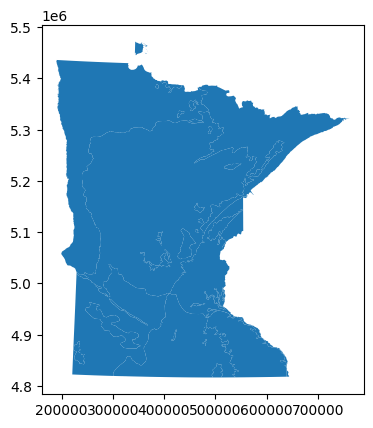

In [27]:
print ("Simple polygon map")
gw_prov_gdf.plot()

In [28]:
print ("Interactive map")
gw_prov_gdf.explore()

Interactive map


Display categorical values on the plot


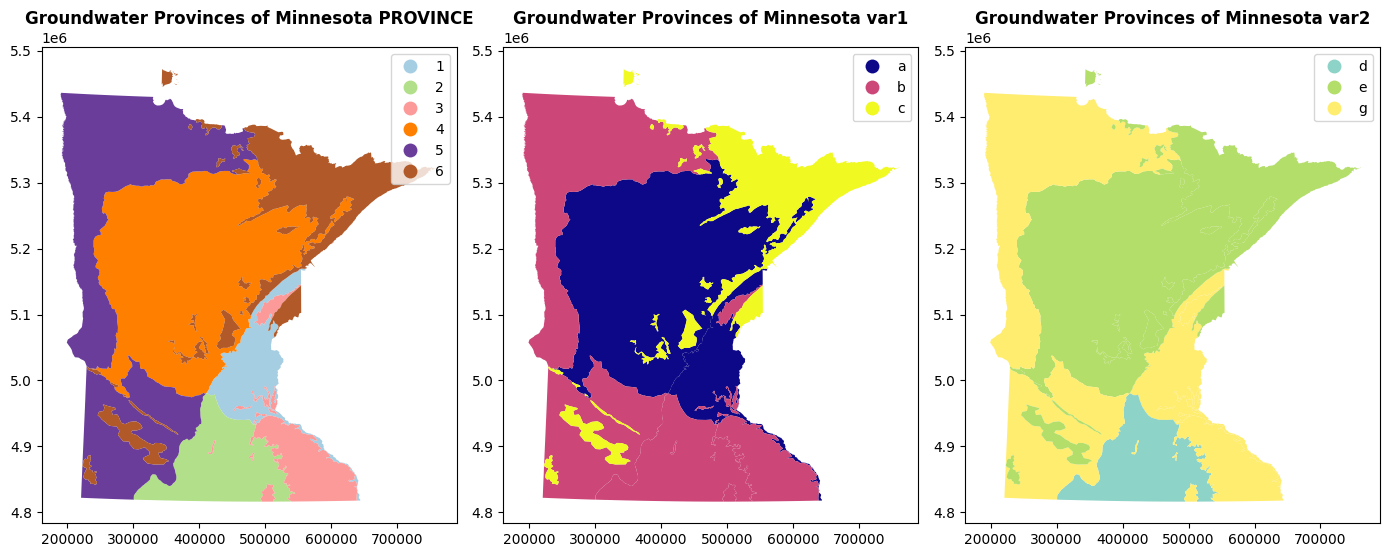

In [29]:
print ("Display categorical values on the plot")
fig, axs = plt.subplots(1,3, figsize=(14,7))
gw_prov_gdf.plot(ax=axs[0], column="PROVINCE", legend=True, cmap="Paired")
axs[0].set_title("Groundwater Provinces of Minnesota PROVINCE", weight="bold")
gw_prov_gdf.plot(ax=axs[1], column="var1", legend=True, cmap="plasma")
axs[1].set_title("Groundwater Provinces of Minnesota var1", weight="bold")
gw_prov_gdf.plot(ax=axs[2], column="var2", legend=True, cmap="Set3")
axs[2].set_title("Groundwater Provinces of Minnesota var2", weight="bold")
plt.tight_layout()

Display continuous values on the plot


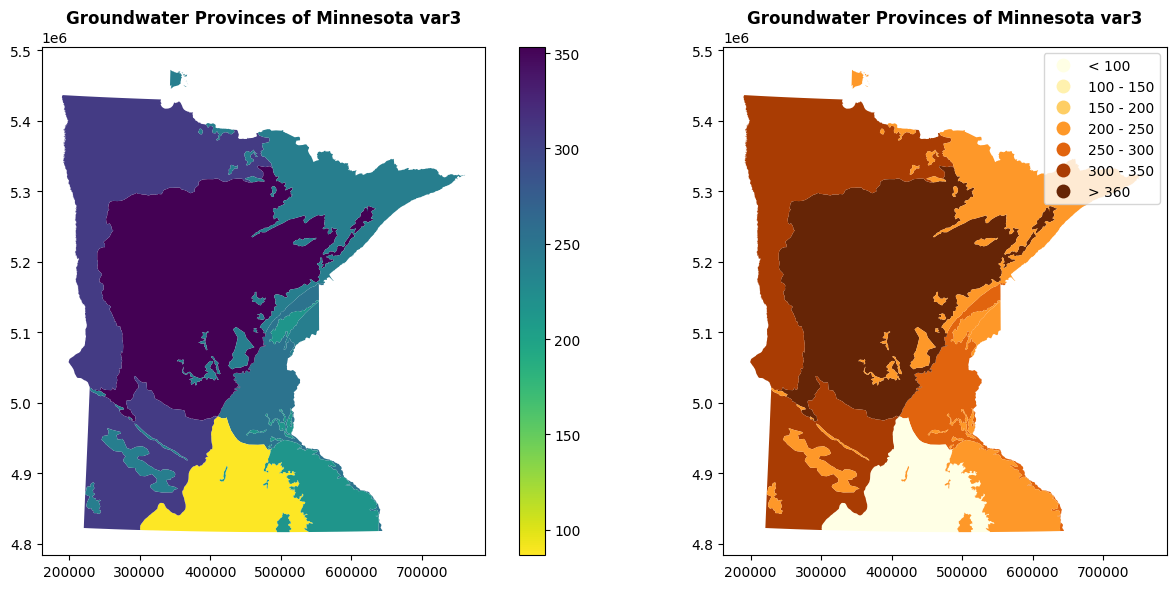

In [30]:
print ("Display continuous values on the plot")
fig, axs = plt.subplots(1,2, figsize=(14,6))
gw_prov_gdf.plot(ax=axs[0], column="var3", legend=True, cmap="viridis_r")
axs[0].set_title("Groundwater Provinces of Minnesota var3", weight="bold")
gw_prov_gdf.plot(ax=axs[1], column="var3", legend=True, scheme="User_Defined", cmap="YlOrBr",
                 classification_kwds=dict(bins=[100,150,200,250,300,350]),
                 legend_kwds={"labels": ["< 100", "100 - 150", "150 - 200", "200 - 250",
                                         "250 - 300", "300 - 350", "> 360"]})
axs[1].set_title("Groundwater Provinces of Minnesota var3", weight="bold")
plt.tight_layout()

## **Working with Raster Data in Python**
### Import Raster Files

Our first step is to read in the raster file that contains our data. For this example, we will be using the *Cropland Data Layer 2020, Minnesota* data.

> The United States Department of Agriculture (USDA), National Agricultural Statistics Service (NASS) Cropland Data Layer (CDL) is a raster, geo-referenced, crop-specific land cover data layer.

For today's workshop, the data has been transformed to represent 3 categories: corn (0), other cropland (1), and non cropland (2). We read in raster data using the `rasterio` package.

In [31]:
cdl_dataset =  rasterio.open("./data/raw/data-lecture-6/cdl3_3km.tif")

### Summarize raster dataset geoproperties

In [32]:
print ("Number of rows is equal to {}".format(cdl_dataset.height))
print ("Number of columns is equal to {}".format(cdl_dataset.width))
print ("Extent of the dataset: {}".format(cdl_dataset.bounds))
print ("Coordinate Reference System: {}".format(cdl_dataset.crs))
print ("NoData value: {}".format(cdl_dataset.nodata))

Number of rows is equal to 218
Number of columns is equal to 194
Extent of the dataset: BoundingBox(left=-91875.0, bottom=2278515.0, right=490125.0, top=2932515.0)
Coordinate Reference System: EPSG:5070
NoData value: 255.0


### Summarize raster data values

In [33]:
cdl_array = cdl_dataset.read(1)
print ("Raster unique values are: {}".format(np.unique(cdl_array)))

Raster unique values are: [  0   1   2 255]


In [34]:
cdl_array = cdl_array.astype(float)
cdl_array[cdl_array==cdl_dataset.nodata] = np.nan
print ("Raster unique values are: {}".format(np.unique(cdl_array)))

Raster unique values are: [ 0.  1.  2. nan]


(0.0, 2.0)

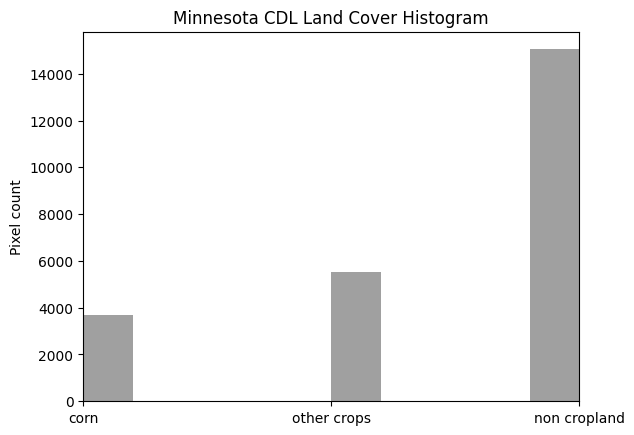

In [36]:
plt.hist(cdl_array.flatten(), facecolor="grey", alpha=0.75)
plt.title("Minnesota CDL Land Cover Histogram")
plt.ylabel("Pixel count")
plt.xticks([0,1,2], labels=["corn", "other crops", "non cropland"])
plt.xlim(0,2)

### Visualize raster data

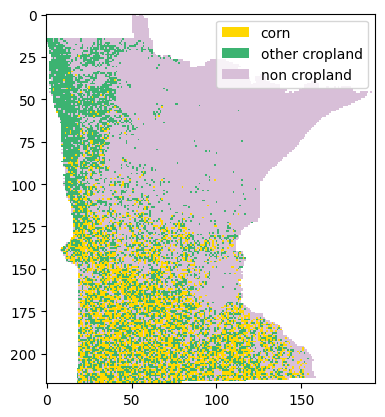

In [37]:
clrs = ["gold", "mediumseagreen", "thistle"]
labels = ["corn", "other cropland", "non cropland"]

cmap, norm = from_levels_and_colors([0,1,2,3], clrs)
plt.imshow(cdl_array, cmap=cmap, norm=norm, interpolation="none")

c = [ mpatches.Patch(facecolor=clrs[i]) for i in range(len(labels))]
plt.legend(c, labels)

## **Layering Features**
To understand better landscape patterns, spatial distribution of features and their interactions, it is often useful to display multiple layers on the same map. To ensure that the layers align, follow these rules:
- all layers need to be in the same coordinate system (here we choose the coordinate system of the land cover raster layer);
- axis lables for raster data need to be updated to display a spatial extent of interest instead of the pixel counts.

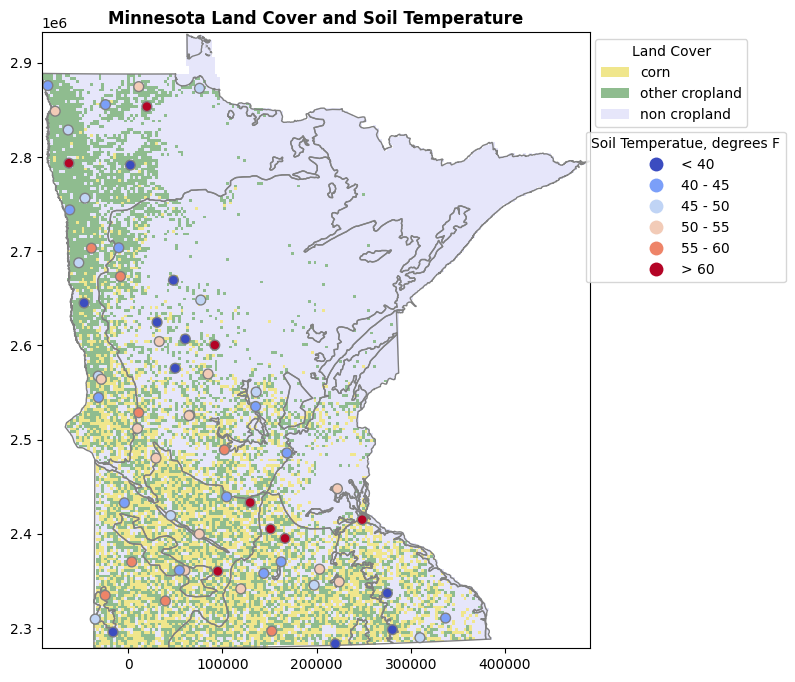

In [38]:
fig, ax = plt.subplots(figsize = (14,8))


plot_extent = plotting_extent(cdl_array, cdl_dataset.transform)
clrs = ["khaki", "darkseagreen", "lavender"]
labels = ["corn", "other cropland", "non cropland"]
cmap, norm = from_levels_and_colors([0,1,2,3], clrs)
ax.imshow(cdl_array, cmap=cmap, norm=norm, interpolation="none", extent=plot_extent)
c = [mpatches.Patch(facecolor=clrs[i]) for i in range(len(labels))]
leg1 = plt.legend(c, labels, bbox_to_anchor=(1.3, 1), title="Land Cover")

gw_prov_gdf.to_crs(cdl_dataset.crs).plot(ax=ax, facecolor="none", edgecolor="grey")

soil_samp_gdf.to_crs(cdl_dataset.crs).plot(ax=ax, column="temp_20211005", legend=True, scheme="User_Defined",
                                           cmap="coolwarm",  edgecolor="grey", markersize=50,
                                           classification_kwds=dict(bins=[40,45,50,55,60]),
                                           legend_kwds={"labels": ["< 40", "40 - 45", "45 - 50",
                                                                   "50 - 55", "55 - 60", "> 60"],
                                                       "bbox_to_anchor":(1.37, 0.85),
                                                        "title":"Soil Temperatue, degrees F"})


plt.title("Minnesota Land Cover and Soil Temperature", weight="bold")
plt.gca().add_artist(leg1)

### Export final map to a file

In [ ]:
fig.savefig("./data-module-1/MN_final_map.jpg", bbox_inches='tight', dpi=150)

## **Tutorial**

### Data
-  `ea_geo.csv` - Malawi Living Standard Measurement Survey Integrated Household Sample (LSMS-IHS) point data are available from https://microdata.worldbank.org/index.php/catalog/3818  
- `mwi_lsms.shp` - Malawi subnational divisions can be downloaded from https://data.humdata.org/dataset/malawi-administrative-level-0-3-boundaries
- `MWI_msk_alt.vrt` - Malawi Digital Elevation Model (DEM) is derived from NASA's Shuttle Radar Topography Mission data product.

For today's workshop, the data has been downloaded, cleaned, transformed, and saved to the directory `./data-module-1/`.

**Question 1. Read and display the head of the `ea_geo.csv` file stored under `./data-module-1/`.**

**Question 2. Which columns store the geographic coordinates? Transform `DataFrame` into `GeoDataFrame` by using these columns. Display the head of the `GeoDataFrame`.**

**Question 3. Create an interactive map to ensure that the data have been properly geocoded.**

**Question 4. Create a static map with 2 subplots: based on columns `dist_road` and `dist_border`. Display values as continuous.**

**Question 5. Read the `mwi_lsms.shp` shapefile located in the `./data-module-1/` folder. Display the first 2 records of `GeoDataFrame`.**

**Question 6. Explore the characteristics of the `GeoDataFrame`.**  
- How many columns does it have?
- How many rows does it have?
- Calculate summary statistics of the numerical fields.

**Question 7. Create an interactive map of the `GeoDataFrame`.**

**Question 8. Create a static map with 2 subplots: based on columns `croplnd` and `poverty`. Display values as continuous.**

**Question 9. Read the Malawi DEM raster file stored as `MWI_msk_alt.vrt`. Convert the data type to float and reset `NoData` values to `np.nan`.**

**Question 10. Explore the characteristics of your raster.**
- How many rows and columns does it have?
- What is the spatial extent of the dataset?
- What is the coordinate reference system?
- Plot a histogram to display the distribution of values.

**Question 11. Plot Malawi DEM array. Use `terrain` as a `cmap` option.**

**Question 12. Display multiple features on the same map:**
- add Malawi DEM (use the coorditate system from this dataset as a reference for others), use `terrain` as `cmap` option;
- add Malawi district boundaries (polygon), display only the edges with `grey` color;
- add Malawi LSMS points, display `dist_agmrkt` column, include the legend, and keep the default `cmap`.